# 0.0. IMPORTS

In [5]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
import pickle
import json
import requests

from IPython.display       import Image
from IPython.core.display  import HTML
from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

In [2]:
# Como executar tudo tem custo de tempo e processamento alto e tem etapas que não precisa, criei esta variável para quando precisar executar tudo.
EXECUTAR_TUDO = False

## 0.1. Helper Functions

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y).values
    
    n = cm.sum()

    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2_corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2_corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    # Configuração do tamanho dos gráficos
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    # Configurações para os gráficos ficarem legíveis, principalmente quando tem vários.
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def ml_error( model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse}, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )



In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [10]:
df_sales_raw = pd.read_csv('dados/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dados/store.csv', low_memory=False)

df_row = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [6]:
df_row.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
819179,440,4,2013-06-27,4065,506,1,0,0,0,d,a,3900.0,4.0,2005.0,1,45.0,2009.0,"Feb,May,Aug,Nov"


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_row.copy()

## 1.1. Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data Dimension

In [9]:
print( 'Número de Linhas: {}'.format(df1.shape[0] ) )
print( 'Número de Colunas: {}'.format(df1.shape[1] ) )

Número de Linhas: 1017209
Número de Colunas: 18


## 1.3. Data Types

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
# competition_distance          
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month  
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year   
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo2_since_week             
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# promo2_since_year             
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May',6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

In [13]:
df1.sample( 5 ).T

,994403,301668,562715,771948,32188
store,609,929,426,39,969
day_of_week,1,4,3,4,5
date,2013-01-21 00:00:00,2014-10-23 00:00:00,2014-02-12 00:00:00,2013-08-08 00:00:00,2015-07-03 00:00:00
sales,5739,5042,4195,3627,4084
customers,592,692,628,507,651
open,1,1,1,1,1
promo,1,1,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,1,0,1,0
store_type,a,a,a,a,a


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'int32', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'int32', 'float64', 'datetime64[ns]'] )

In [18]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
254016,0,a,c,0,Dec
415117,0,a,a,0,Jun


## 1.7.1 Numerical Attributes

In [19]:
# Tendencia central - mean, ]median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersão - std, min, max, range, knew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#Concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns =['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\laurivan\anaconda3\envs\dsEmProducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

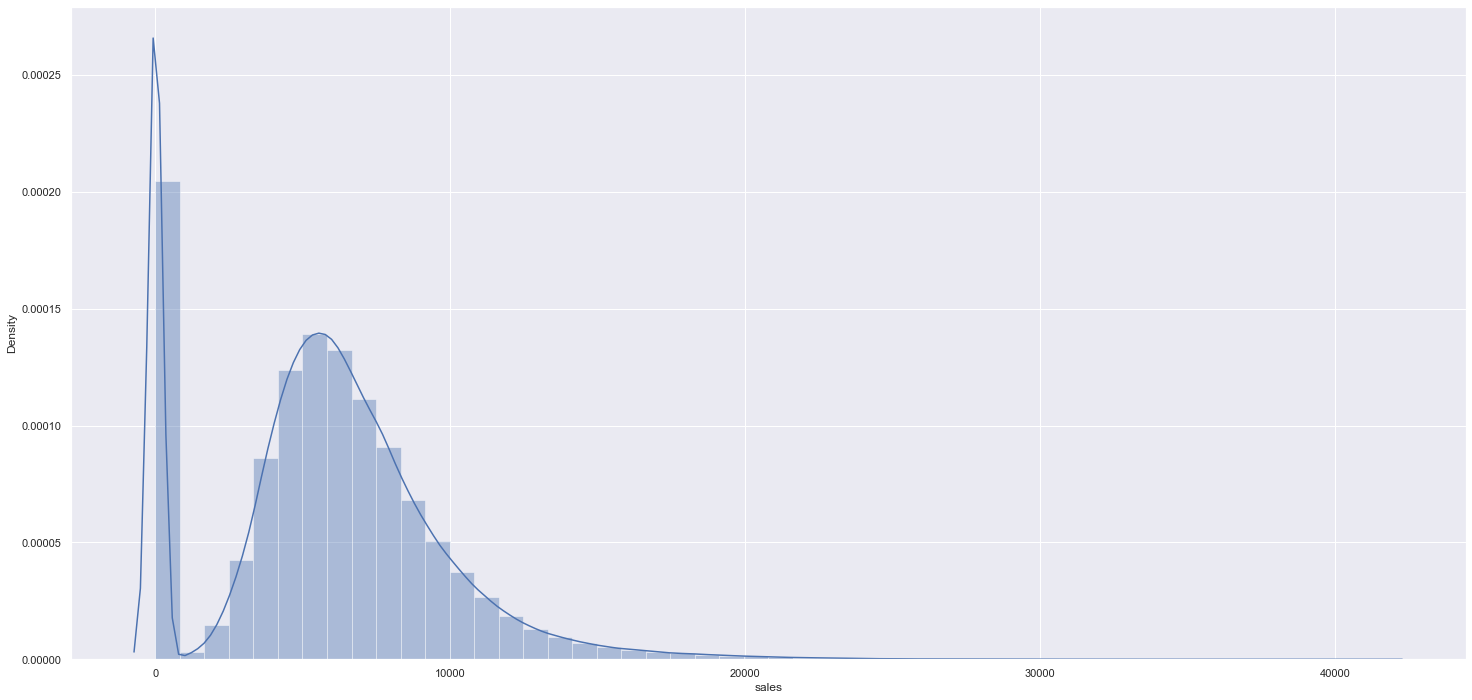

In [20]:
 sns.distplot( df1['sales'] )

## 1.7.2 Categorical Attributes

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

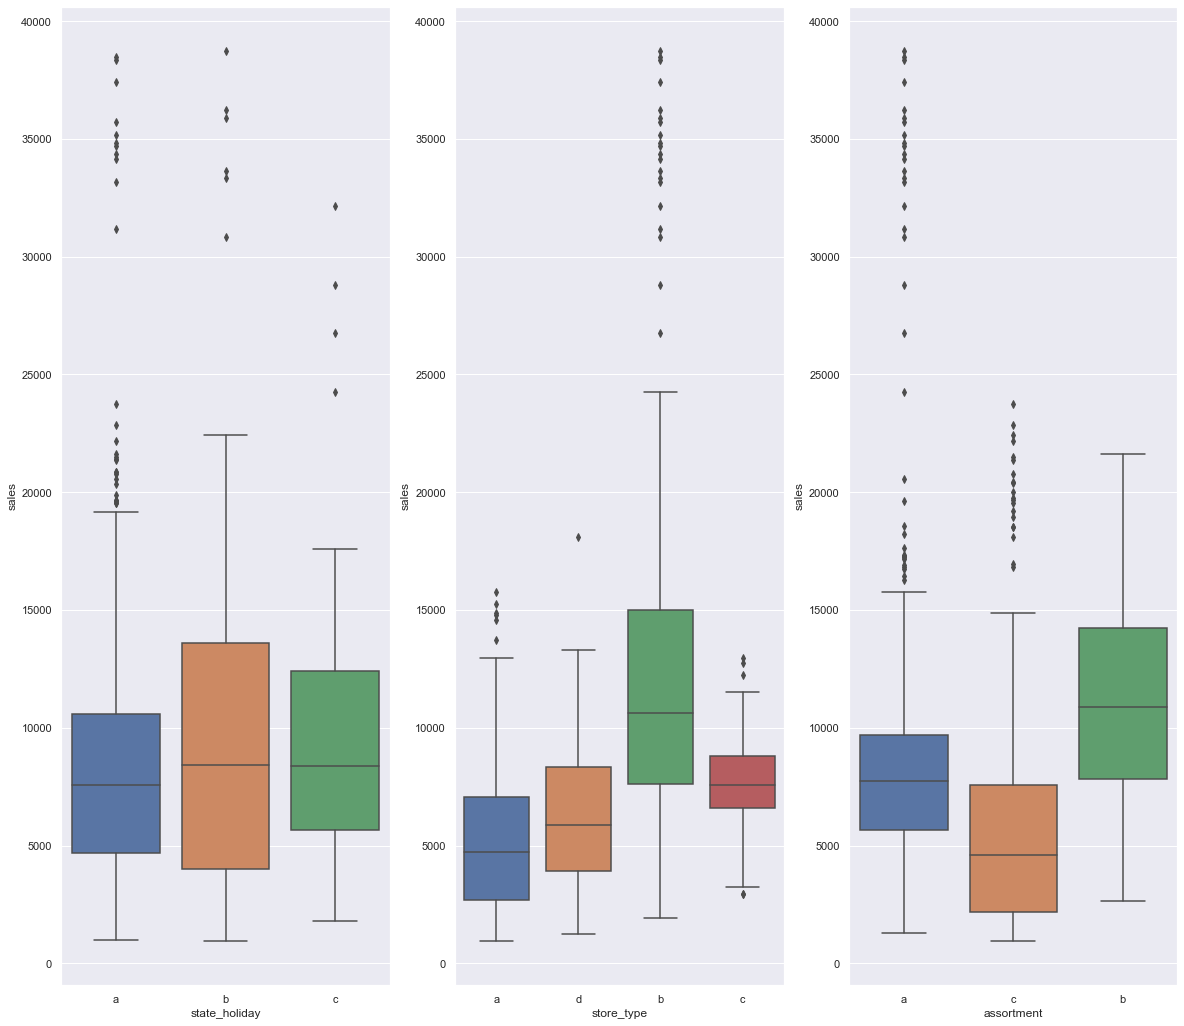

In [22]:
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0 ) ]

# Redimensiona Gráficos
plt.figure( figsize=(20, 18))

plt.subplot( 1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [23]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

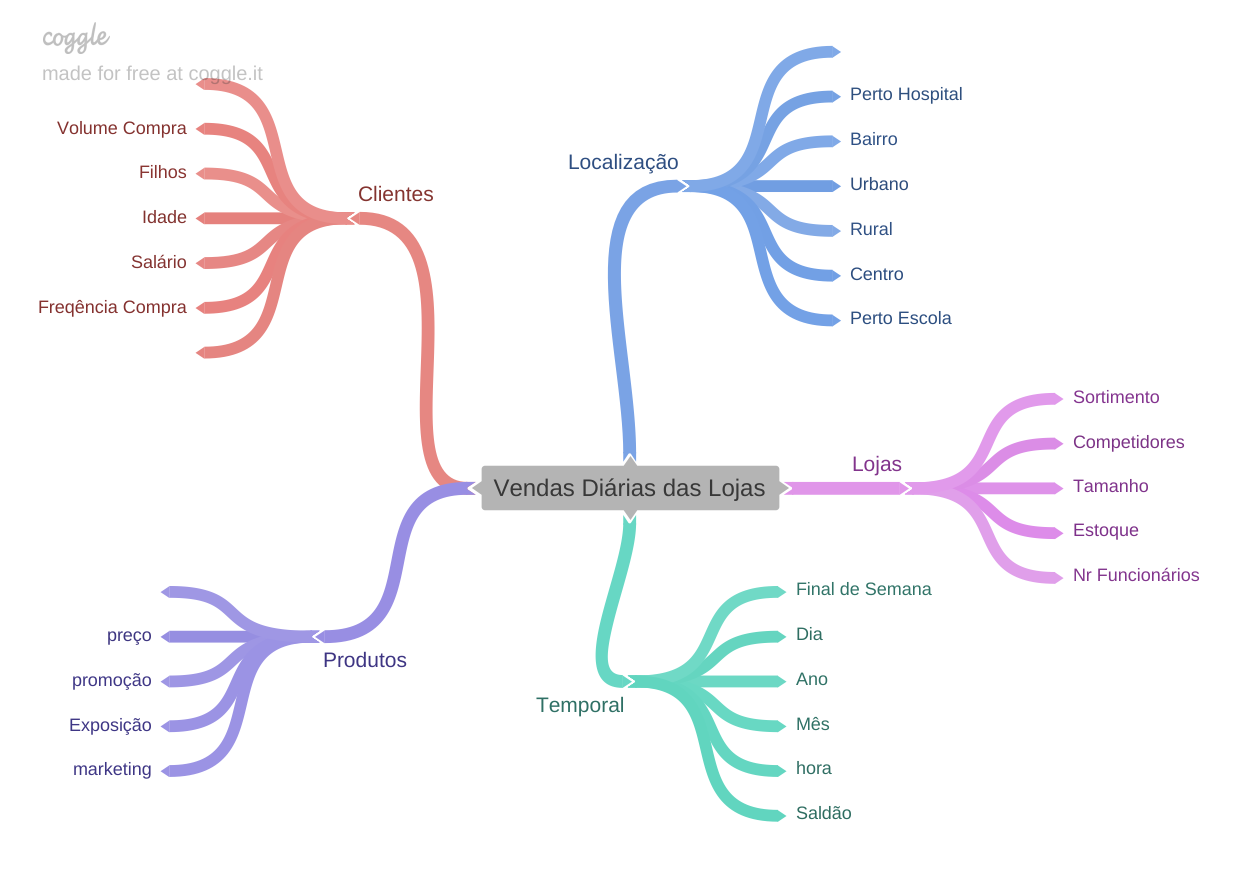

In [24]:
Image( 'img/MapaMentalHipoteses.png' )

## 2.2. Criação das Hipóteses

### 2.1.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( int ).astype( str ) + '-' + df2['promo2_since_week'].astype( int ).astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [28]:
df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]

## 3.2. Selecao das Colunas

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [31]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1.Variável Resposta

C:\Users\laurivan\anaconda3\envs\dsEmProducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

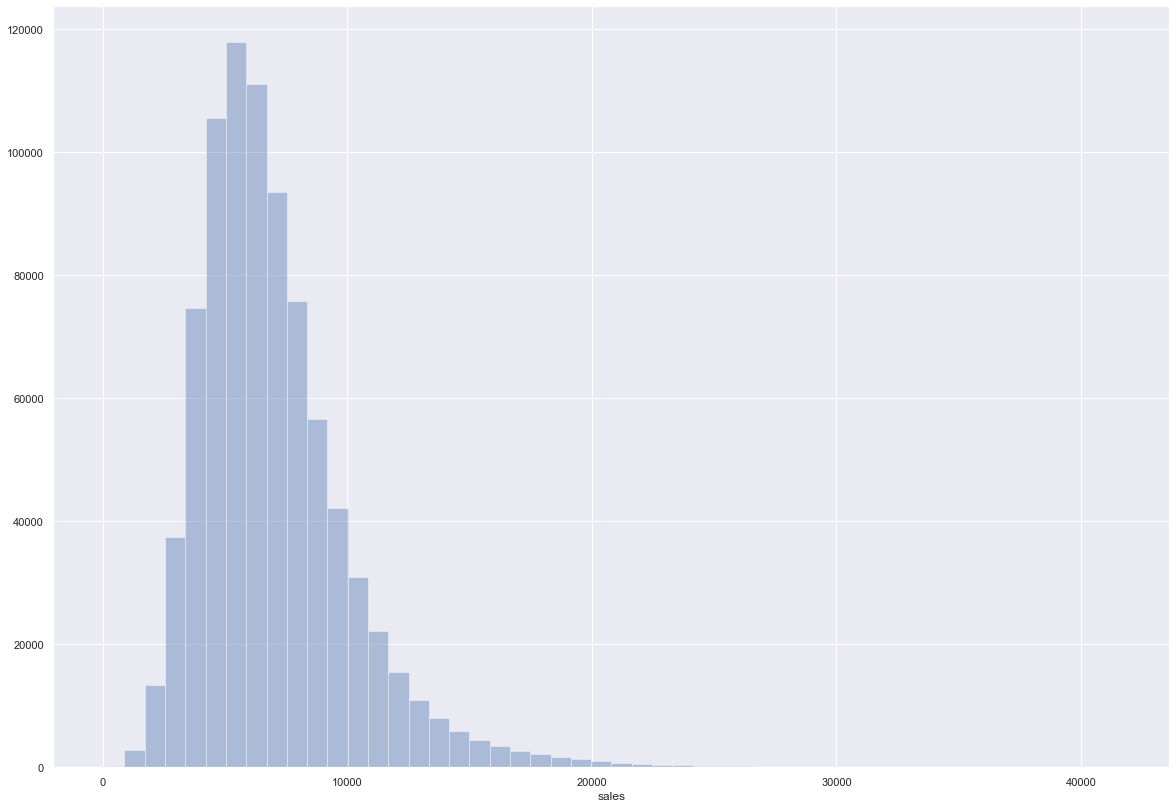

In [32]:
# Redimensiona gráfico
plt.figure( figsize=(20, 14))

# kde=False Para remover a desindade e deixar apenas o histograma
sns.distplot( df4['sales'], kde=False )

### 4.1.2. Variável Numérica

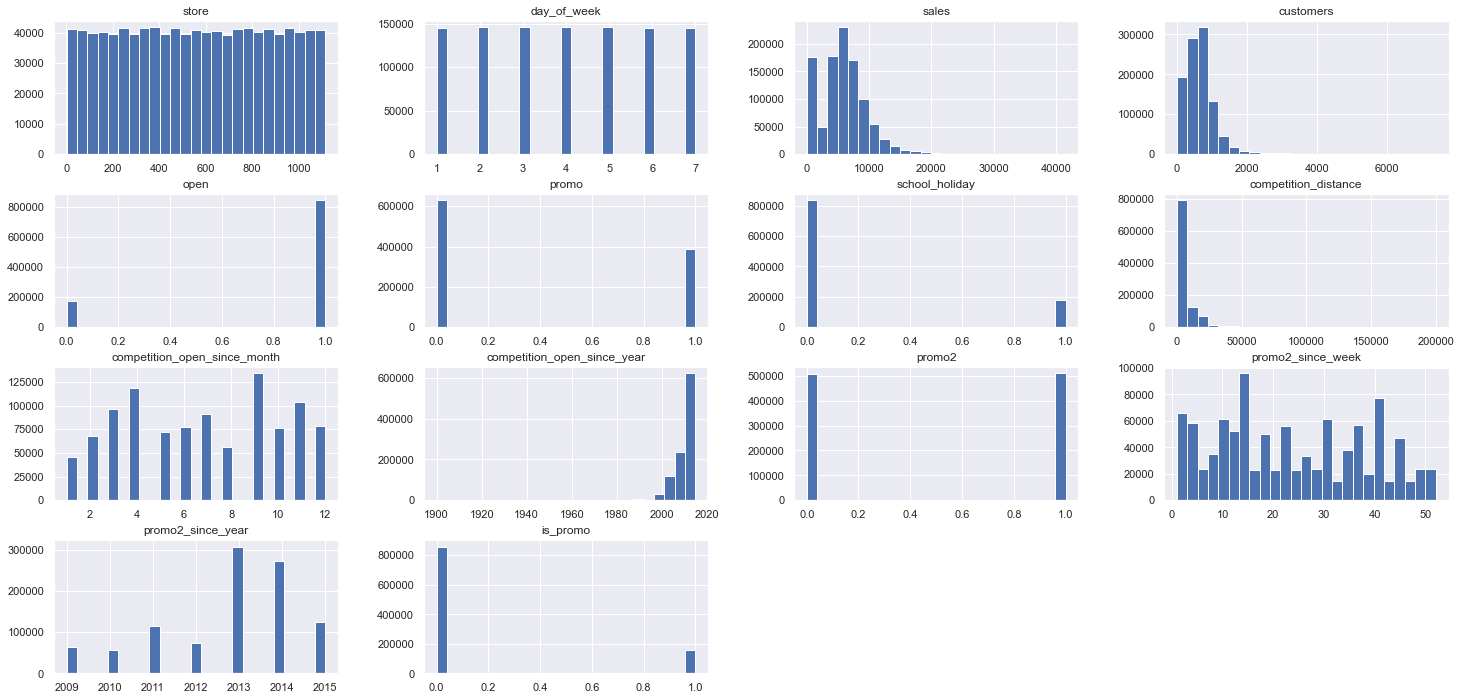

In [33]:
num_attributes.hist( bins=25 );

### 4.1.3. Variável Categórica

In [34]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [35]:
df4['state_holiday'].describe()

count          844338
unique              4
top       regular_day
freq           843428
Name: state_holiday, dtype: object

C:\Users\laurivan\anaconda3\envs\dsEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\laurivan\anaconda3\envs\dsEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\laurivan\anaconda3\envs\dsEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

<AxesSubplot:xlabel='sales', ylabel='Density'>

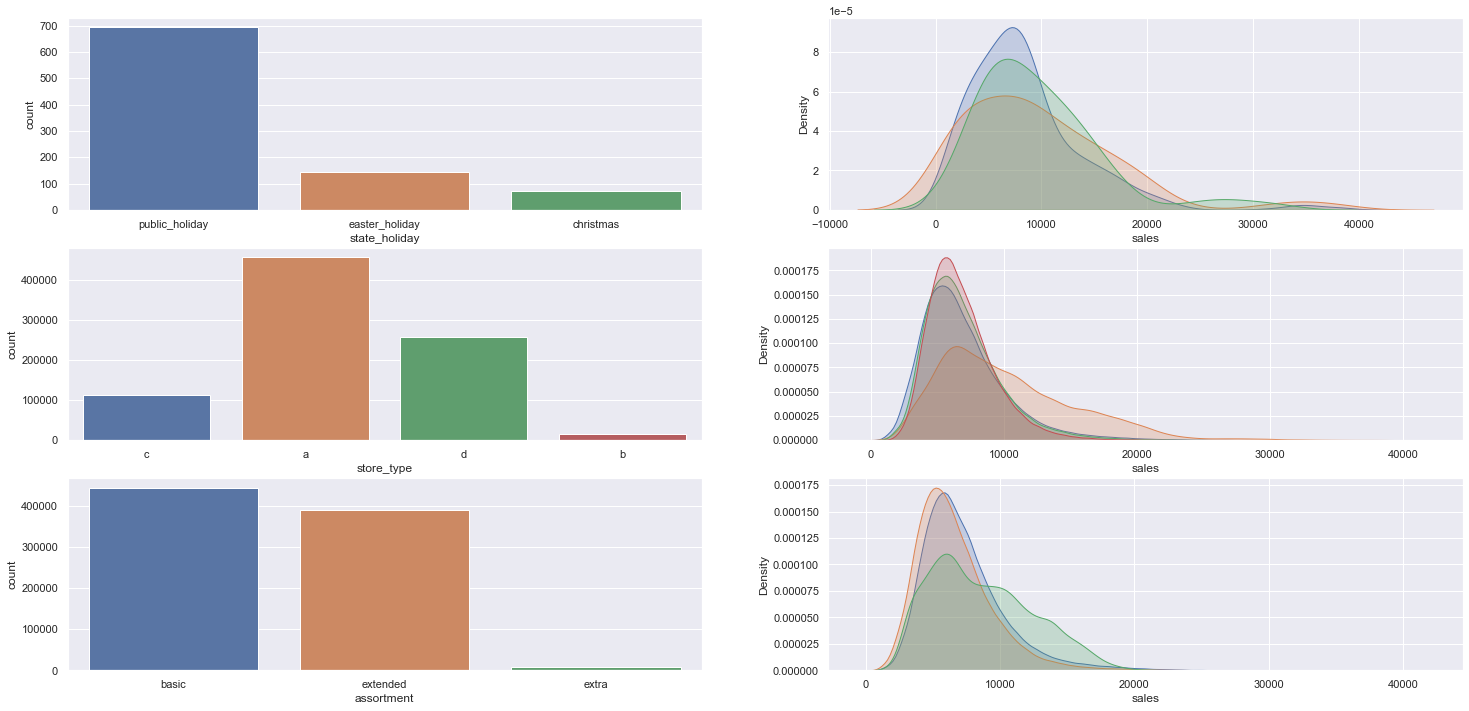

In [36]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**Falsa** pois lojas com maior sortimento vendem menos

<AxesSubplot:xlabel='year_week'>

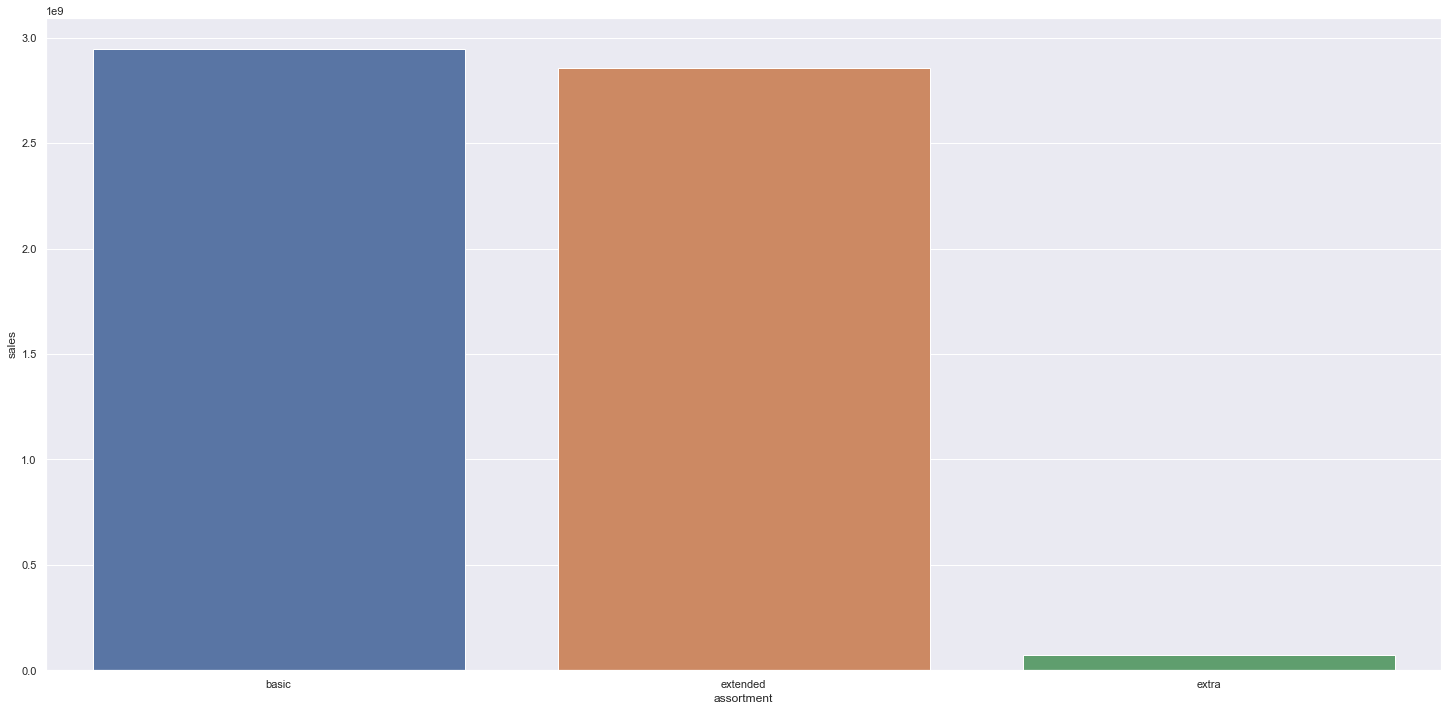

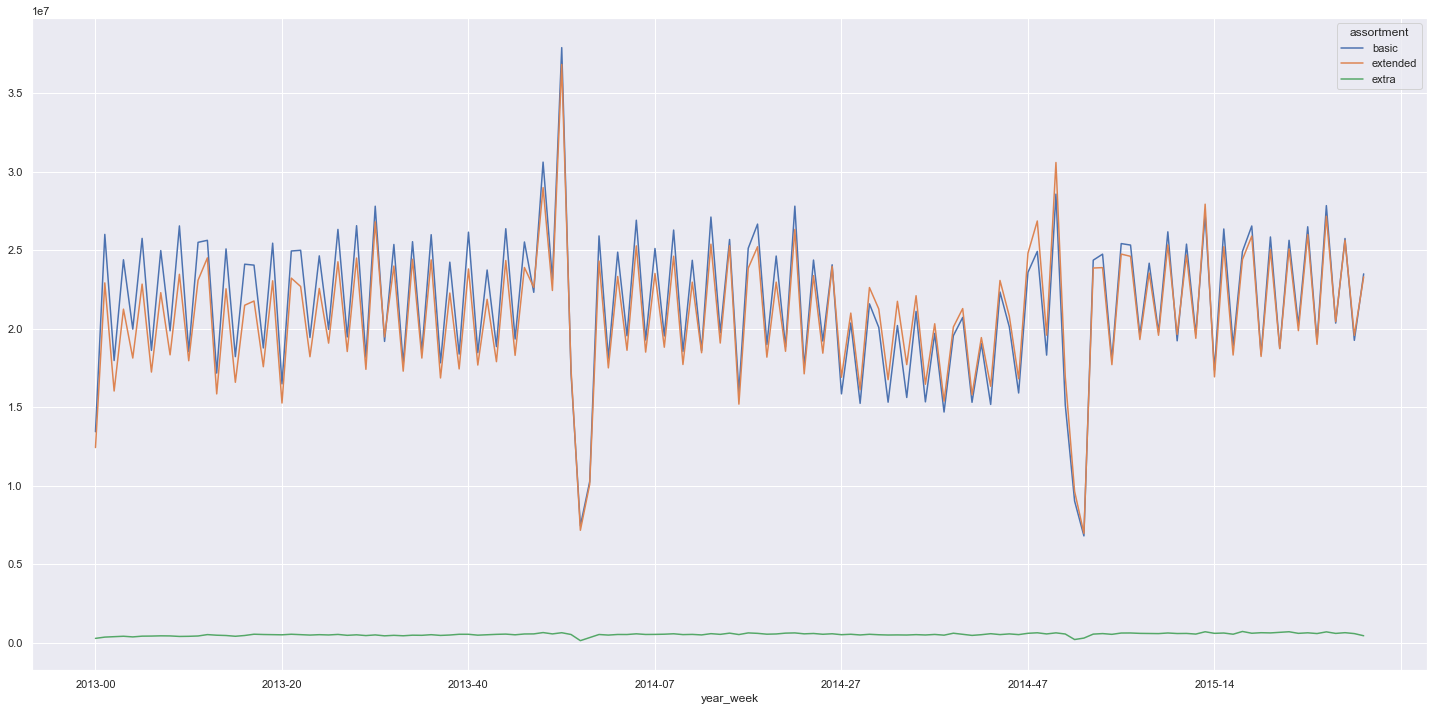

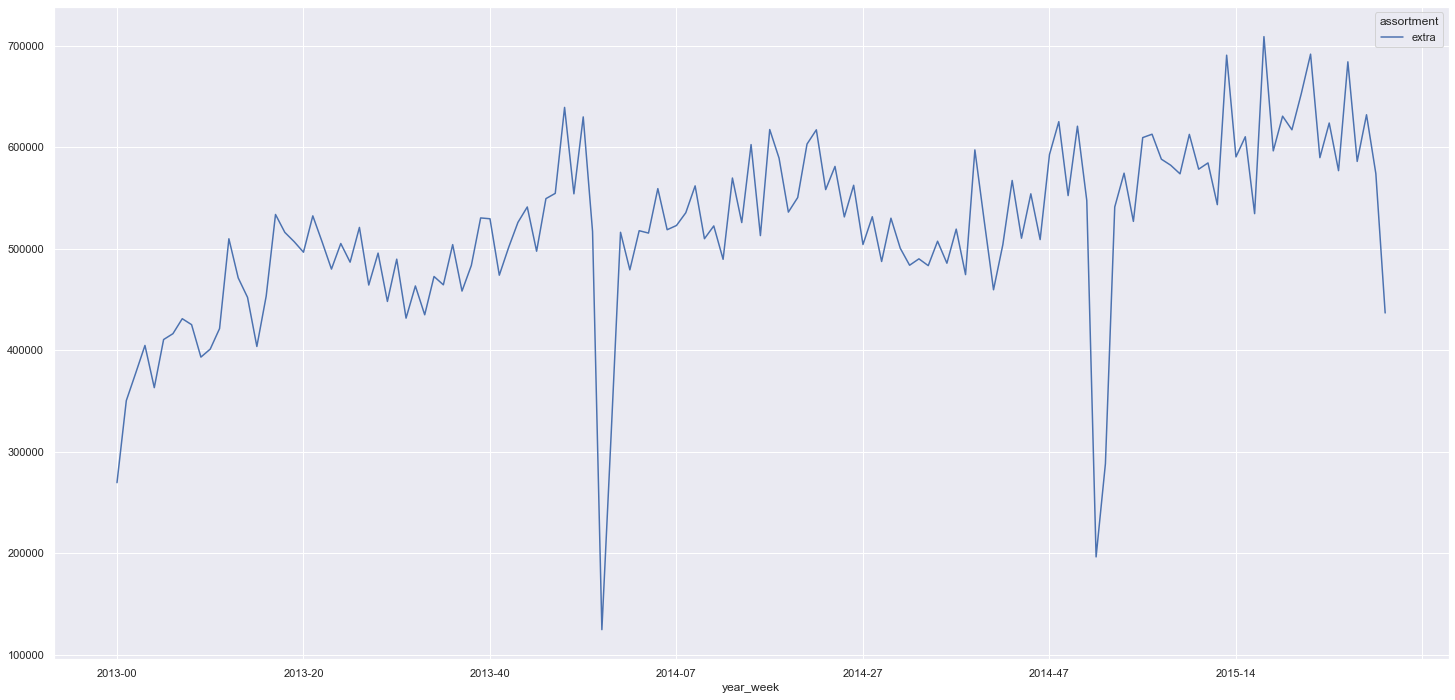

In [37]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[ aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
***FALSA*** Lojas com Competidores mais próximos vendem mais.

<AxesSubplot:>

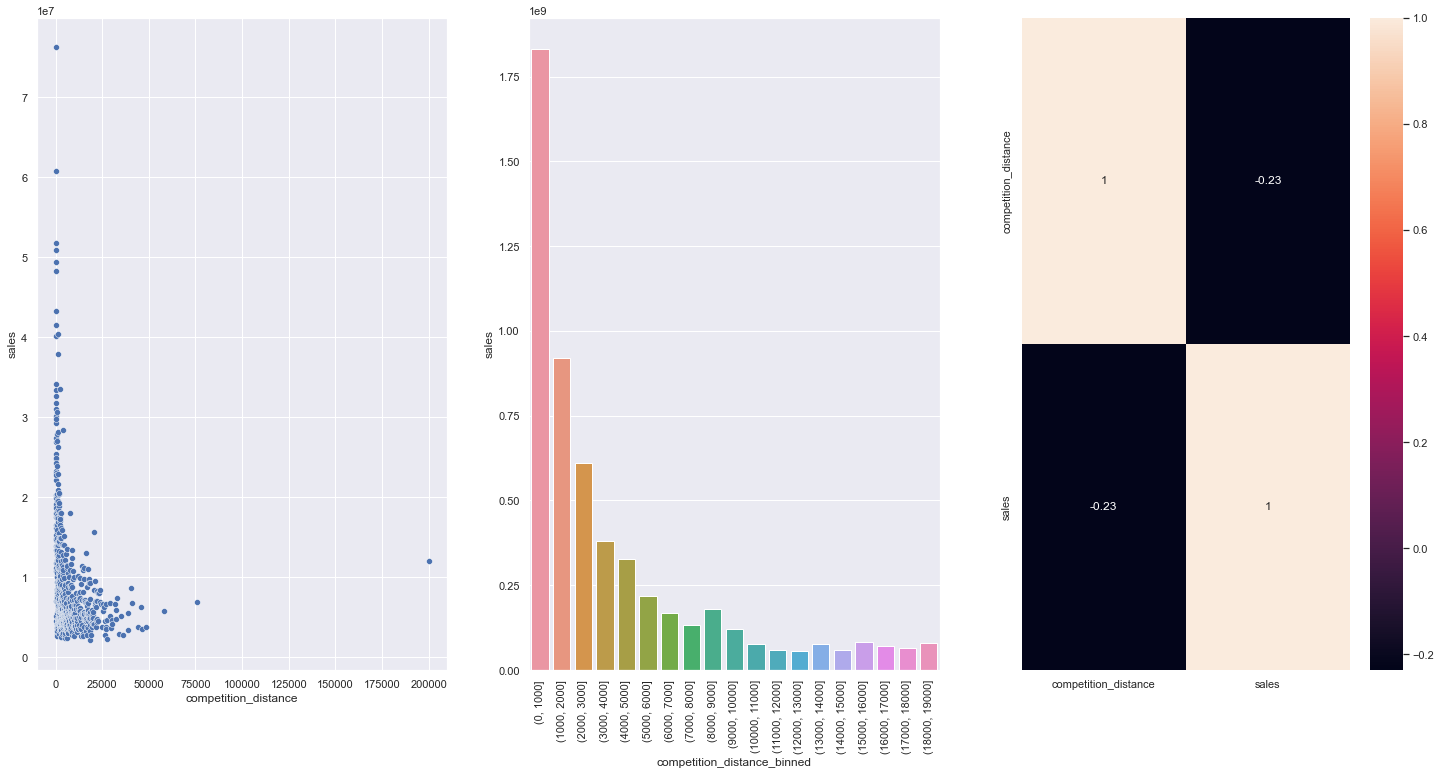

In [38]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
# sns.barplot( x='competition_distance', y='sales', data=aux1);

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut ( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90)


plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True)

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
***FALSA*** Lojas com competidores a mais tempo vendem menos.

<AxesSubplot:>

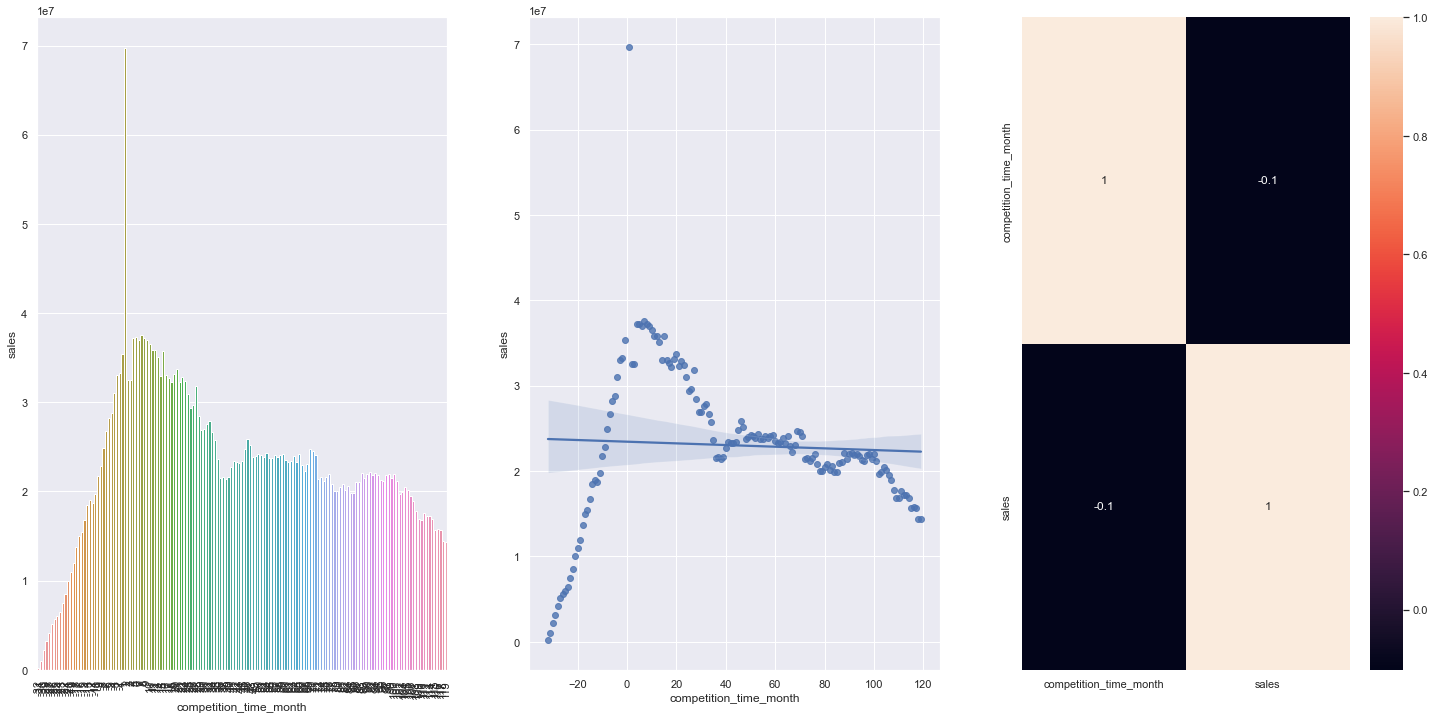

In [39]:
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
***Falsa*** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

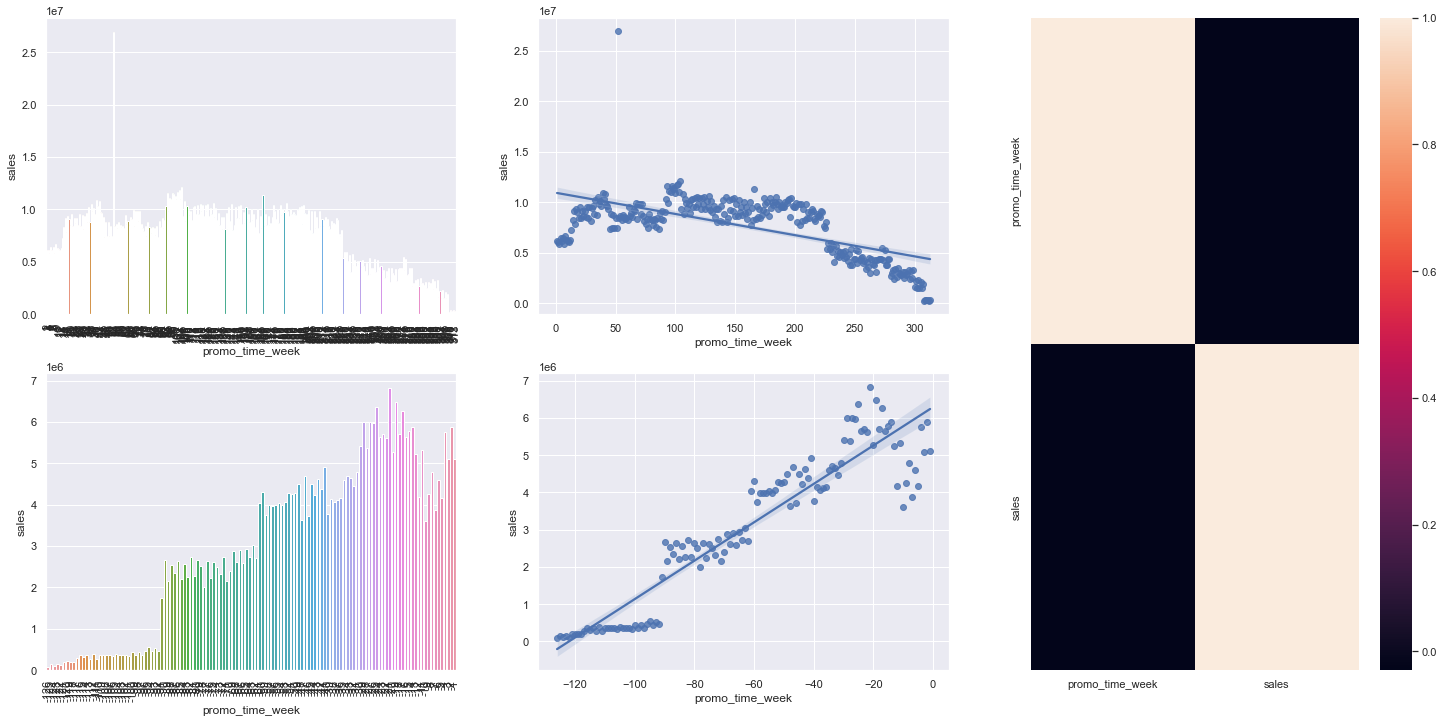

In [40]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # Promo Extendida
sns.barplot( x='promo_time_week', y='sales', data=aux2)
plt.xticks( rotation='90' );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2)

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # Promo Regular
sns.barplot( x='promo_time_week', y='sales', data=aux3)
plt.xticks( rotation='90' );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3)

plt.subplot( grid[0:,2] )
sns.heatmap( aux1.corr( method='pearson' ) );

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais. </s>

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
***Falsa*** lojas com promoções consecutivas vendem menos.

In [41]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


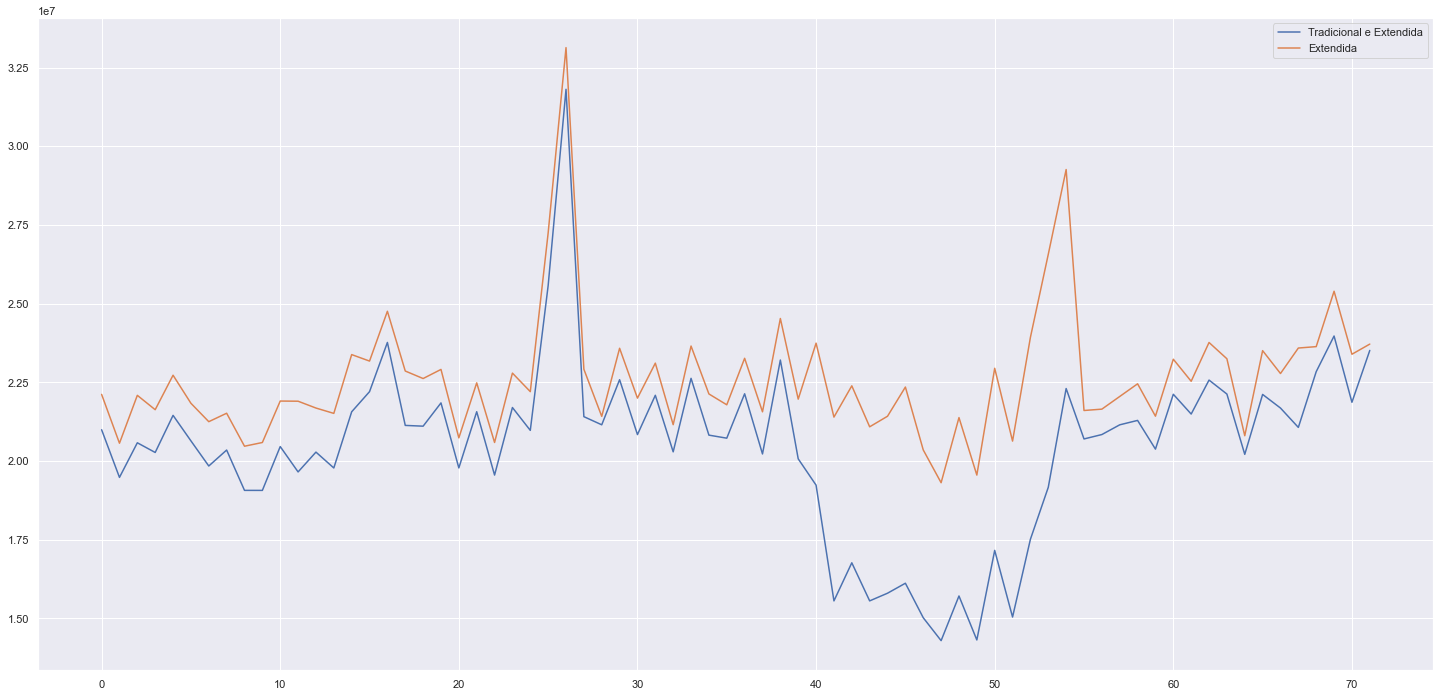

In [42]:
## Período de promoção tradicional e extendida
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()


## Período de promoção tradicional e extendida
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux1.plot( ax=ax )

ax.legend( labels=['Tradicional e Extendida', 'Extendida'] )


### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
***Falsa*** Lojas abertas durante o feriado do natal vendem menos.

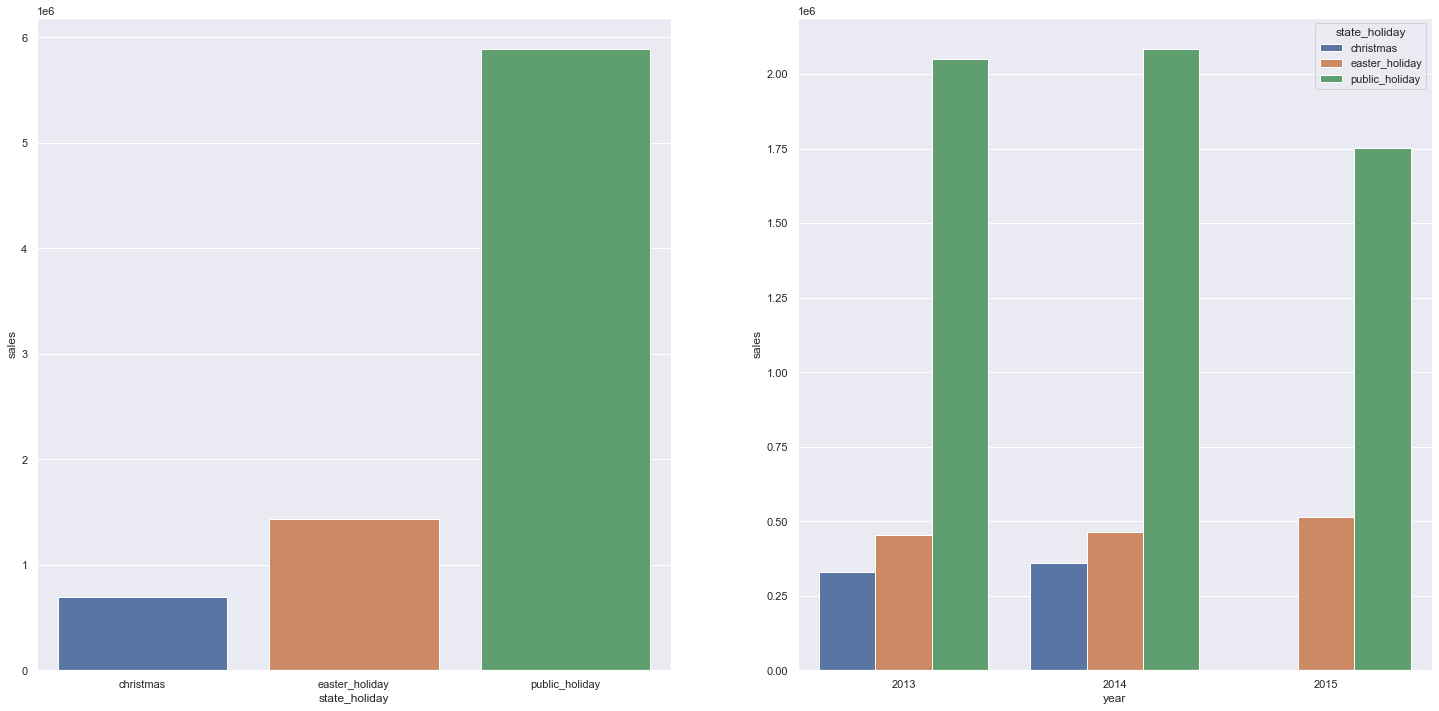

In [43]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H9.** Lojas deveriam vender mais ao longo dos anos.
***Falso*** Loja vendem menos ao longo do ano

<AxesSubplot:>

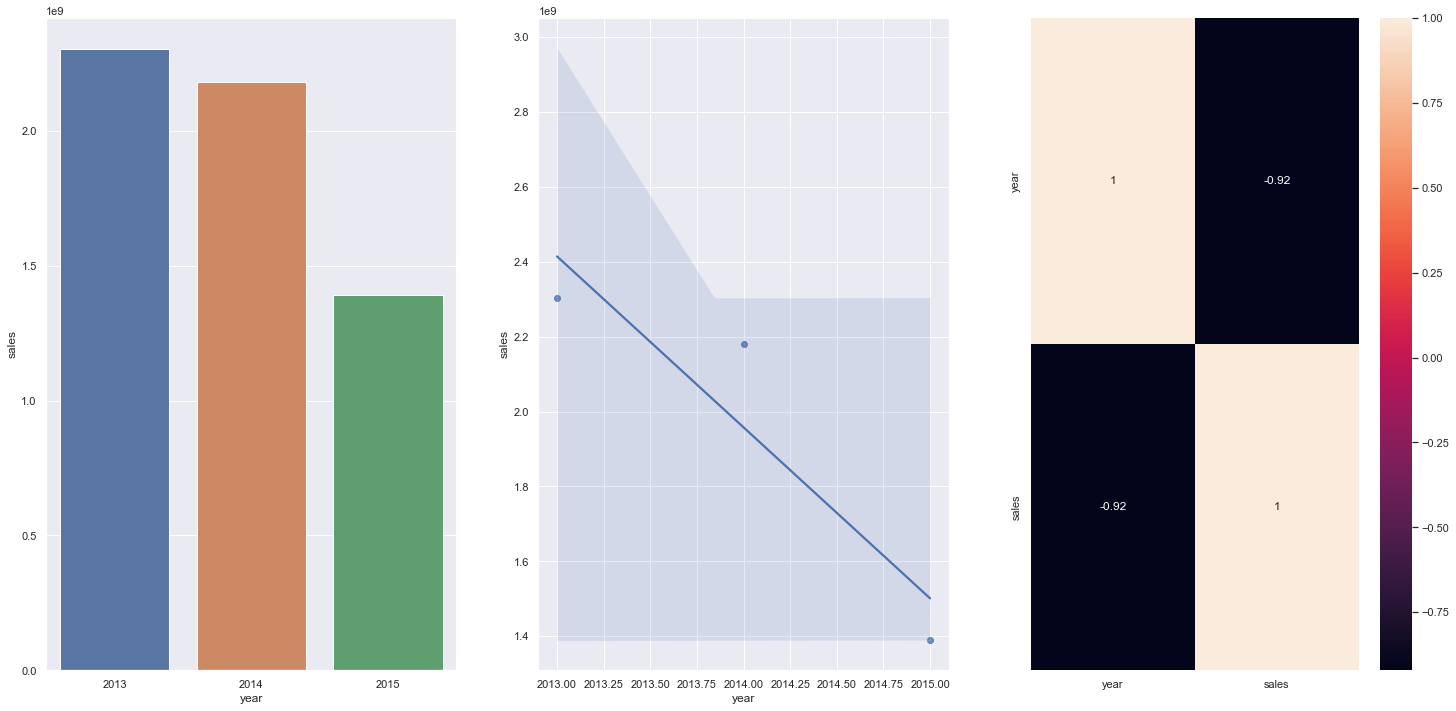

In [44]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

In [45]:
aux1['year'].drop_duplicates()

0    2013
1    2014
2    2015
Name: year, dtype: int64

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
***Falso*** Loja vendem menos no segundo semestre do ano

<AxesSubplot:>

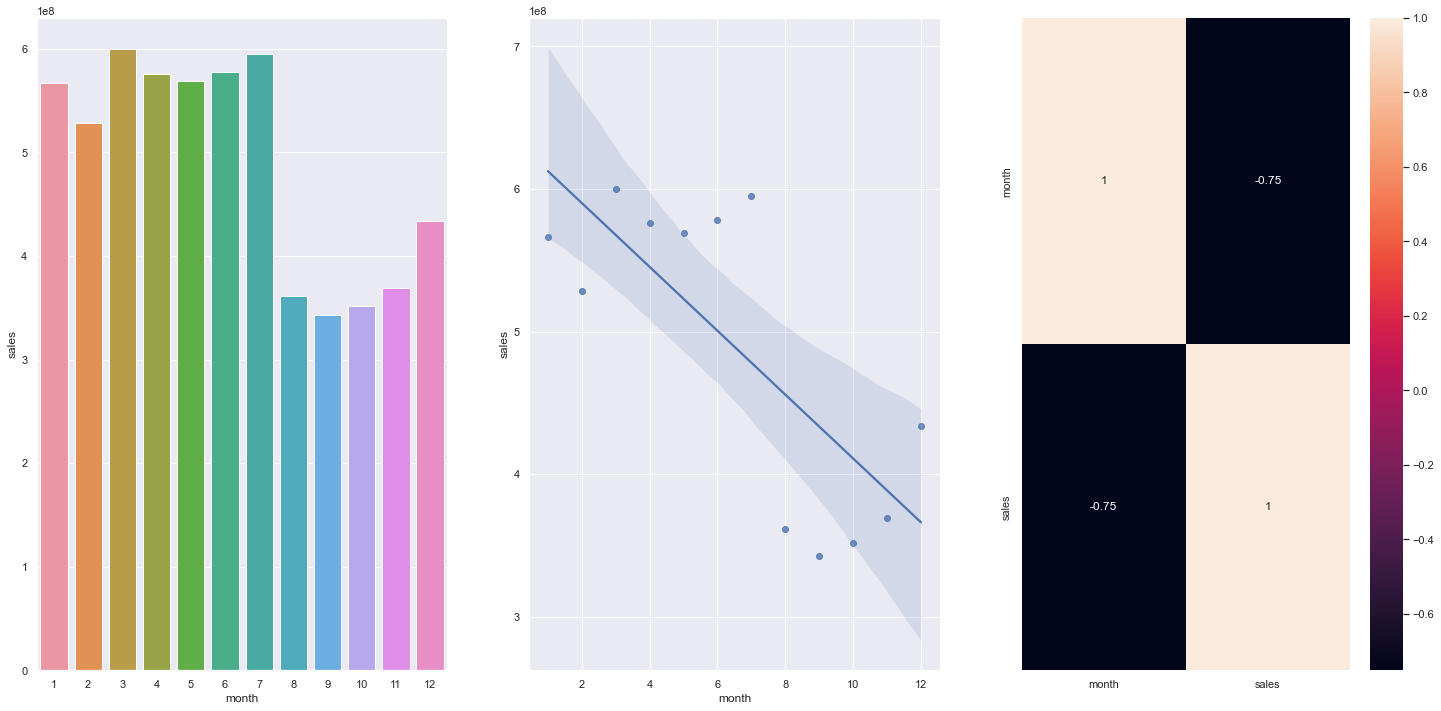

In [46]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
***Verdadeira*** Pois as lojas vendem mais depois do dia 10

In [47]:
aux1['before_after'] = df4['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux1.head()

,month,sales,before_after
0,1,566728724,after_10_days
1,2,528734410,after_10_days
2,3,599831906,after_10_days
3,4,575895295,after_10_days
4,5,569248217,after_10_days


<AxesSubplot:xlabel='before_after', ylabel='sales'>

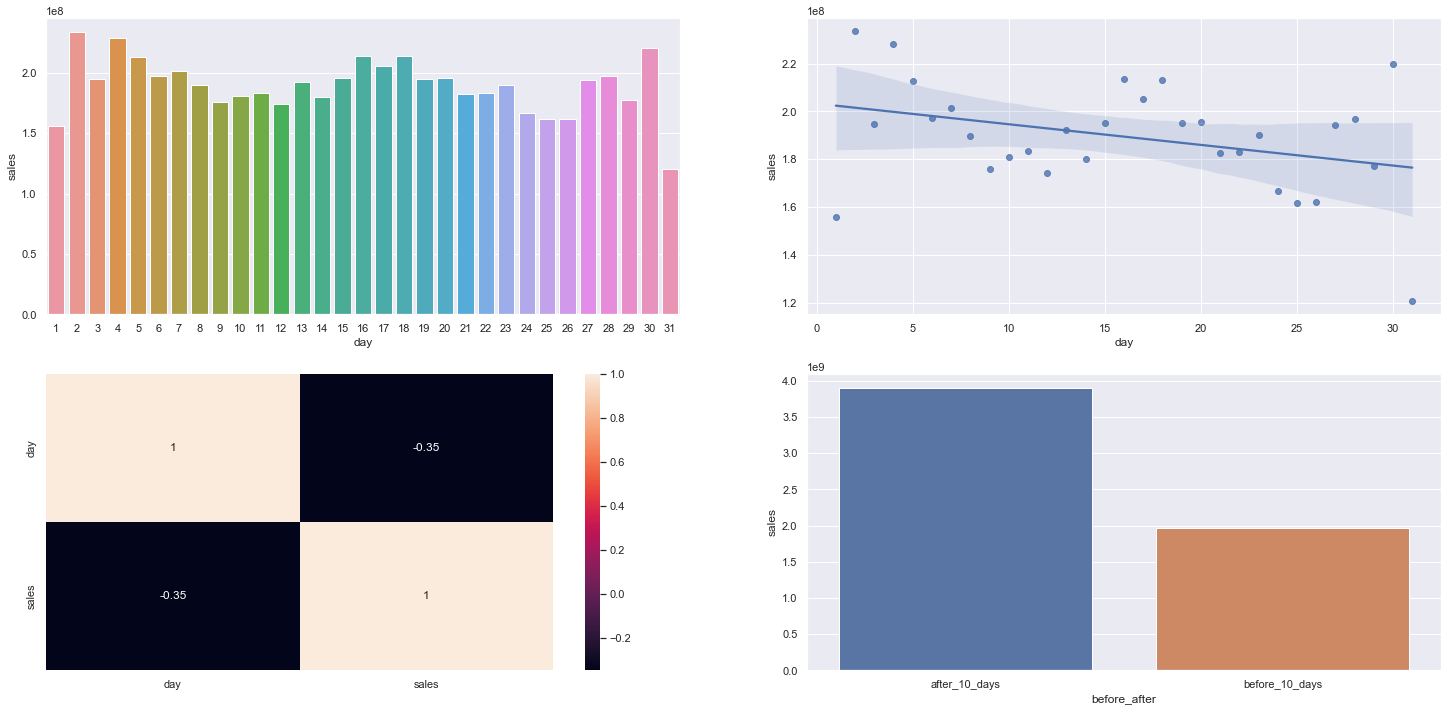

In [48]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1)

plt.subplot( 2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1)

plt.subplot( 2, 2, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

plt.subplot( 2, 2, 4)
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )

aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2)

### **H12.** Lojas deveriam vender menos aos finais de semana.
***Verdadeira*** lojas vendem menos nos finais de semana.

<AxesSubplot:>

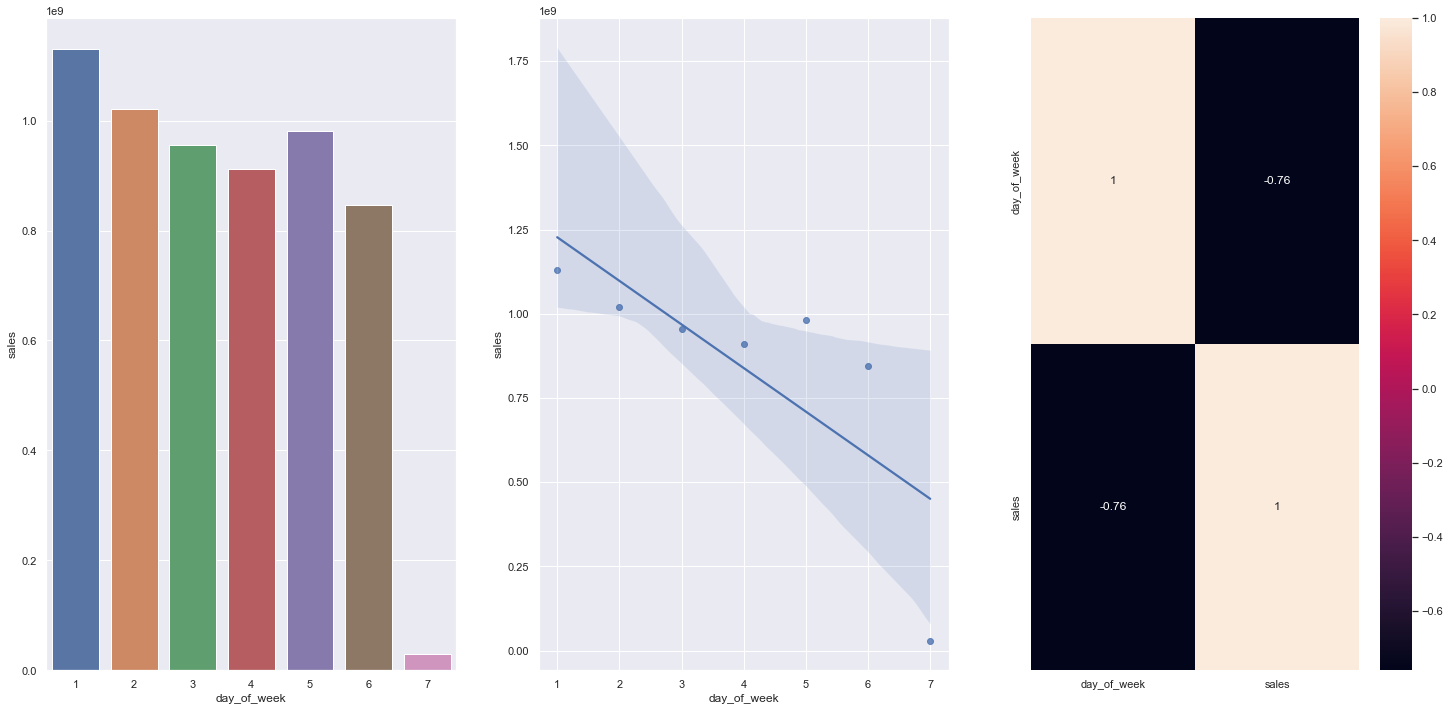

In [49]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**Verdadeira** Lojas vendem menos durante os feriados escolares, exceto meses de julho e agosto

<AxesSubplot:xlabel='month', ylabel='sales'>

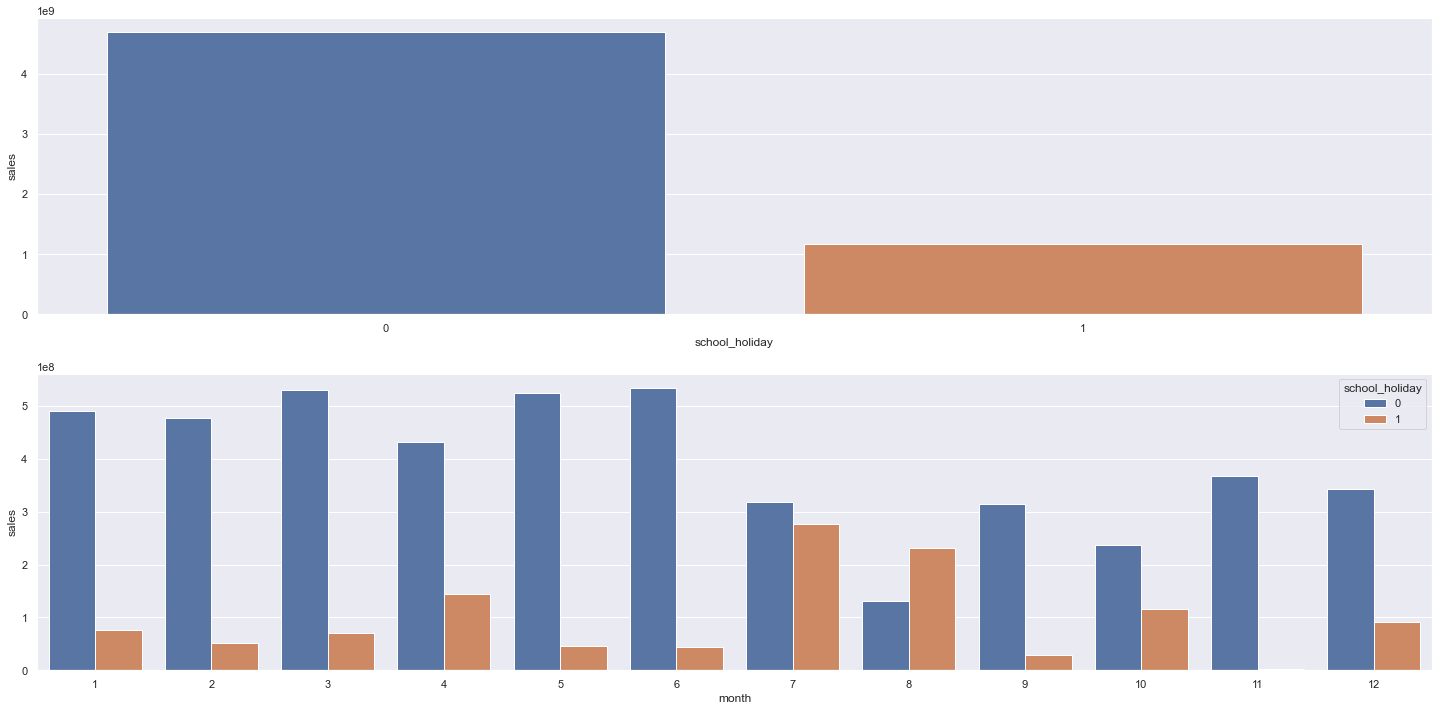

In [50]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1)

plt.subplot( 2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2)

# plt.subplot( 1, 3, 3)
# sns.heatmap( aux1.corr( method='pearson' ), annot=True )

## 4.3. Analise Multivariada

### 4.3.1. Atributos Numéricos

<AxesSubplot:>

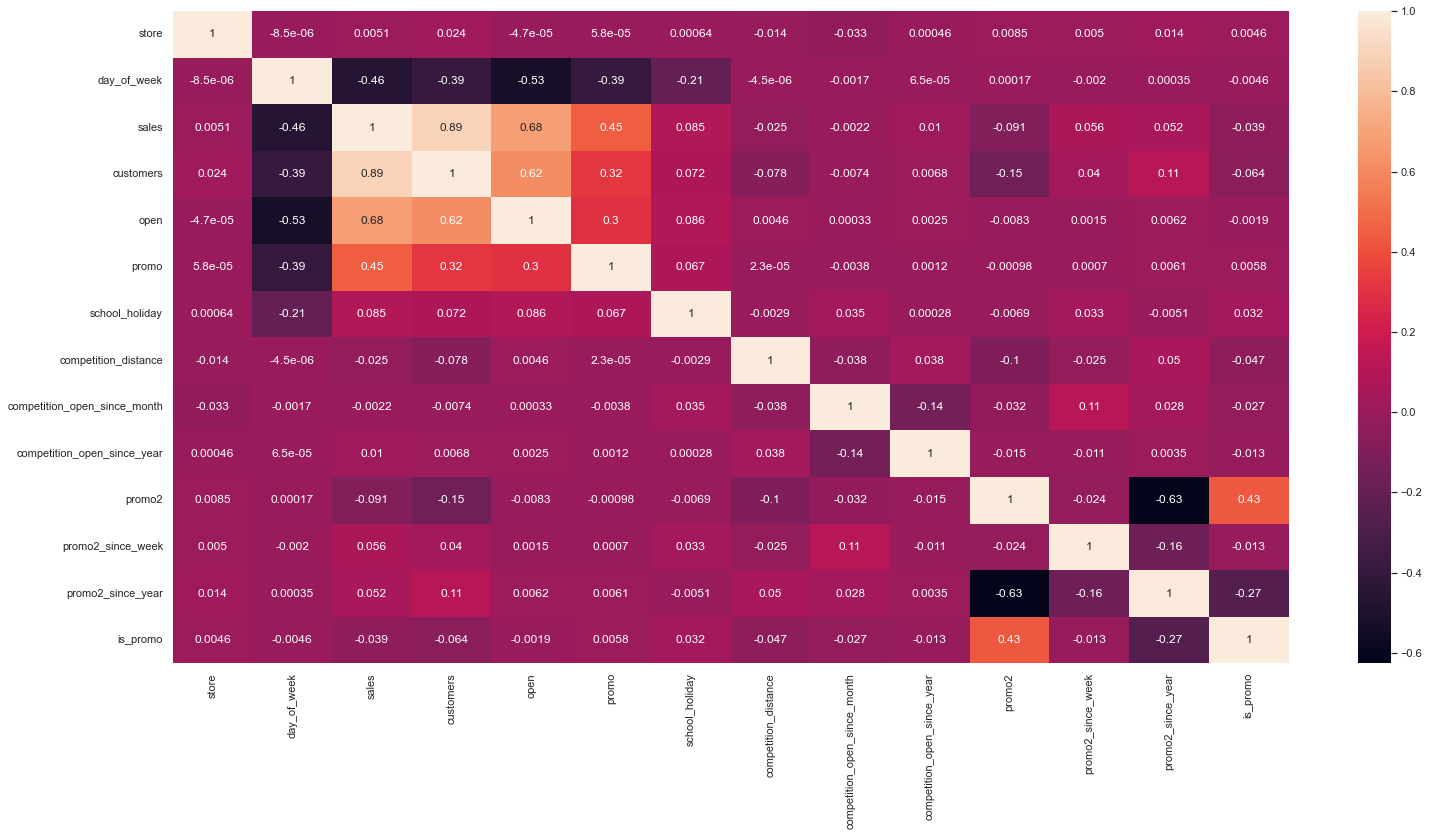

In [51]:
correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True)

### 4.3.2. Atributos Categóricos

<AxesSubplot:>

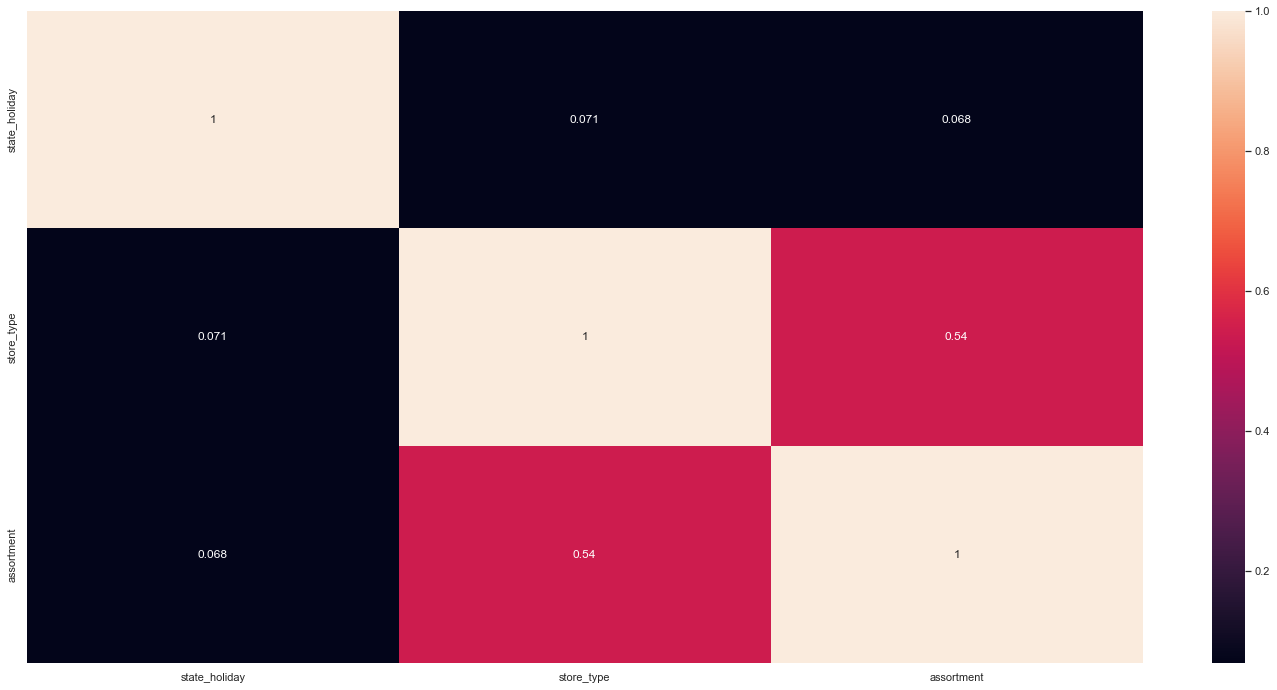

In [52]:
# Apenas dados categóricos
a = df4.select_dtypes( include='object' )

# Calculando V de cramer
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Dataset Final
d = pd.DataFrame( {'state_holiday' : [a1, a2, a3],
               'store_type' : [a4, a5, a6],
               'assortment' : [a7, a8, a9]})
d.set_index( d.columns, inplace=True )

sns.heatmap( d, annot=True )

# 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS

In [53]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open('parameter/competition_distance_scaler.pkl', 'wb' ) )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open('parameter/competition_time_month_scaler.pkl', 'wb' ) )

# promo time week 
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open('parameter/promo_time_week_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open('parameter/year_scaler.pkl', 'wb' ) )

## 5.3. Transformação

### 5.3.1. Encoding

In [55]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

In [56]:
# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open('parameter/store_type_scaler.pkl', 'wb' ) )

In [57]:
# assortment - Ordinal Encoding
assortment_dic = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dic )

### 5.3.2. Response Variable Transformation

In [58]:
df5['sales'] = np.log1p( df5['sales'] )

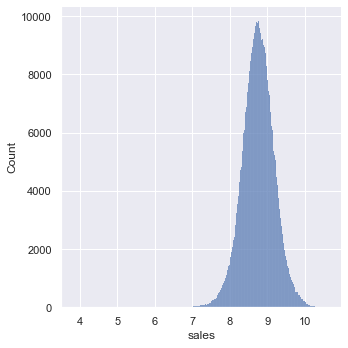

In [59]:
# Ver como ficou a distribuição
sns.displot( df5['sales'] )

### 5.3.3. Nature Transformation

<img src='img/transformacao_natureza_ciclica.jpg' >

**Usando o círculo trigonométrico podemos calcular o ângulo entre as distâncias dos meses.**

In [60]:
# day of week - Reinicia o ciclo a cada 7 dias
reinicia_ciclo = 7
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/reinicia_ciclo ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/reinicia_ciclo ) ) )

# month
reinicia_ciclo = 12
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/reinicia_ciclo ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/reinicia_ciclo ) ) )

# day - Como tem mêses que tem 28,30,31 dias usei como base 30 para todos.
reinicia_ciclo = 30
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/reinicia_ciclo ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/reinicia_ciclo ) ) )

# week of year
reinicia_ciclo = 52
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/reinicia_ciclo ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/reinicia_ciclo ) ) )

# 6.0. PASSO 06 - FEATURE SELECTION

In [61]:
df6 = df5.copy()

## 6.1. Split Dataframe into training and test dataset

In [62]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [63]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [64]:
df6[['store', 'date']].groupby( 'store' ).min().reset_index()['date'][0] - datetime.timedelta( days=7*6 )

Timestamp('2012-11-21 00:00:00')

In [65]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

In [66]:
print( 'Training Min Date {}'.format( X_train['date'].min() ) )
print( 'Training Max Date {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date {}'.format( X_test['date'].min() ) )
print( 'Test Max Date {}'.format( X_test['date'].max() ) )

Training Min Date 2013-01-01 00:00:00
Training Max Date 2015-06-18 00:00:00

Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.2. Boruta as feature selector

In [67]:
X_train.drop( ['date', 'sales'], axis=1).values

array([[ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -8.09016994e-01,  1.20536680e-01, -9.92708874e-01],
       [ 2.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -8.09016994e-01,  1.20536680e-01, -9.92708874e-01],
       [ 3.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -8.09016994e-01,  1.20536680e-01, -9.92708874e-01],
       ...,
       [ 7.69000000e+02,  0.00000000e+00,  1.00000000e+00, ...,
         9.78147601e-01,  1.20536680e-01,  9.92708874e-01],
       [ 9.48000000e+02,  0.00000000e+00,  1.00000000e+00, ...,
         9.78147601e-01,  1.20536680e-01,  9.92708874e-01],
       [ 1.09700000e+03,  0.00000000e+00,  1.00000000e+00, ...,
         9.78147601e-01,  1.20536680e-01,  9.92708874e-01]])

In [68]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

**Como Boruta demora de 4 a 5 horas para executar vou deixar comentado e usando apenas o resultado que foi obtido na execução**

In [69]:
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, X_train_n )

### 6.2.1.  Best Features from Boruta

In [70]:
# cols_selected = boruta.support_.tolist()

# # Best Features
# x_train_sf = X_train.drop( ['date', 'sales'], axis=1 ).values
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist()

# # Not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

### 6.3.  Manual Feature Selection

In [71]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [72]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [73]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [74]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )
## 7.2. Linear Regression Model
# Performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.2.1. Linear Regression Model - Cross validation

In [75]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [76]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lr.predict( x_test )

# Performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1867.143498,0.289627,2683.031638


## 7.3.1. Lasso - Cross validation

In [77]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [78]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# Performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


## 7.4.1. Random Forest Regressor - Cross validation

In [79]:
if EXECUTAR_TUDO:
    rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
    rf_result_cv

## 7.5. XGBoost Regressor

In [80]:
# model
model_xgb = xgb.XGBRegressor().fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# Performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958205,0.130309,1238.550843


## 7.5.1. XGBoost Regressor - Cross validation

In [81]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1064.95 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [82]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1867.143498,0.289627,2683.031638


### 7.6.2. Real Performance - Cross Validation

In [83]:
if EXECUTAR_TUDO:
    modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
    modelling_result_cv

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [84]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [85]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [86]:
#final_result

## 8.2. Final Model

In [87]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [88]:
model_xgb_tuned = pickle.load( open( 'model/model_rossmann.pkl', 'rb') )

In [89]:
# # model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                     n_estimators=param_tuned['n_estimators'], 
#                                     eta=param_tuned['eta'], 
#                                     max_depth=param_tuned['max_depth'], 
#                                     subsample=param_tuned['subsample'],
#                                     colsample_bytee=param_tuned['colsample_bytree'],
#                                     min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

In [90]:
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.056876,0.114527,1088.444637


**Para não precisar ficar treinando toda vez será salvo o modelo em um arquivo e quando necessário podemos importar ele.**

In [91]:
pickle.dump( model_xgb_tuned, open('model/model_rossmann.pkl', 'wb' ) )

# 9.0. PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [92]:
df9 = X_test[ cols_selected_boruta_full ]

# Rescale
df9.loc[:, 'sales']  = np.expm1( df9['sales'] )
df9.loc[:, 'predictions'] = np.expm1( yhat_xgb_tuned )

C:\Users\laurivan\anaconda3\envs\dsEmProducao\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\laurivan\anaconda3\envs\dsEmProducao\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


## 9.1. Business Performance

In [93]:
# Sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [94]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
819,820,365795.375000,363660.493573,367930.256427,2134.881427,0.169580
775,776,175204.437500,174655.915052,175752.959948,548.522448,0.115851
385,386,259234.453125,258673.390506,259795.515744,561.062619,0.071532
622,623,254514.093750,253703.017261,255325.170239,811.076489,0.125643


<AxesSubplot:xlabel='store', ylabel='MAPE'>

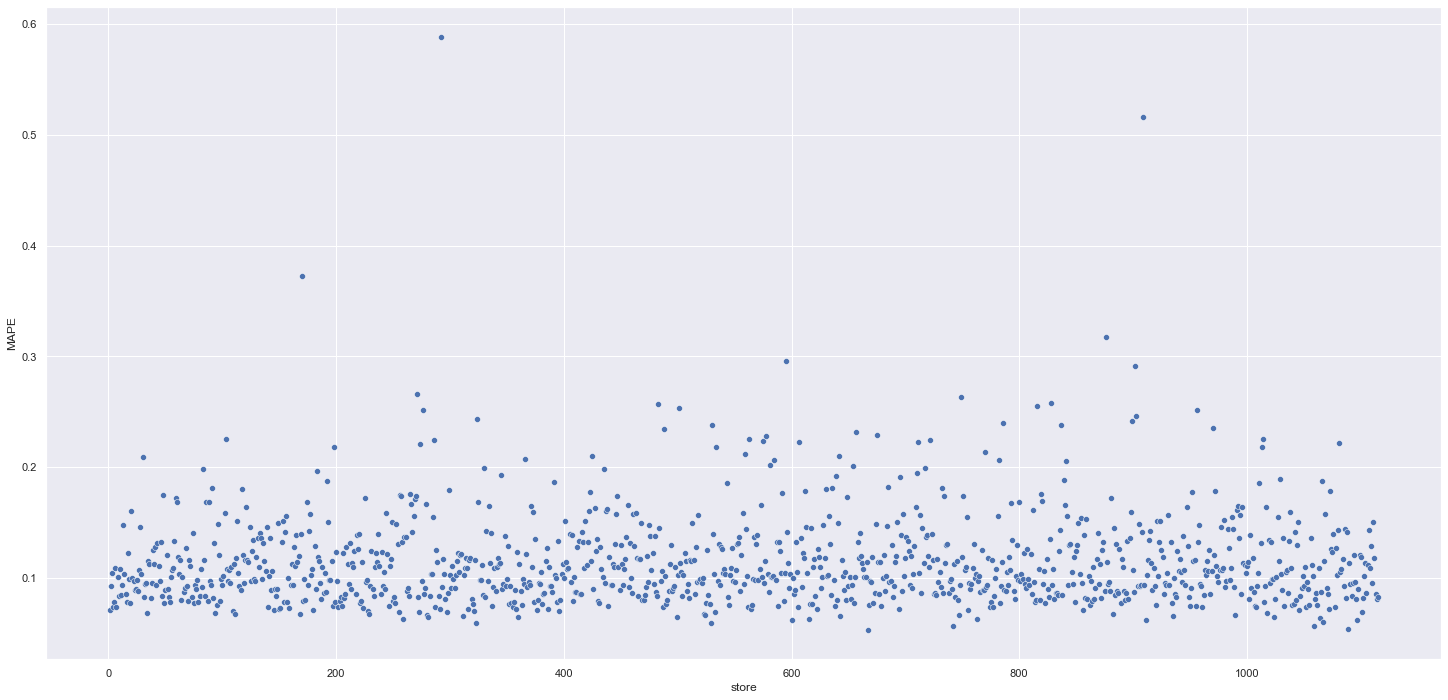

In [95]:
sns.scatterplot( x='store', y='MAPE', data=df92)

## 9.2. Total Performance

In [96]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$287,260,416.00"
1,worst_scenario,"R$286,409,667.53"
2,best_scenario,"R$288,111,145.53"


## 9.3. Machine Learning Performance

In [97]:
df9.loc[:,'error'] = df9['sales'] - df9['predictions']
df9.loc[:,'error_rate'] = df9['predictions'] / df9['sales']

C:\Users\laurivan\anaconda3\envs\dsEmProducao\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


C:\Users\laurivan\anaconda3\envs\dsEmProducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\laurivan\anaconda3\envs\dsEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

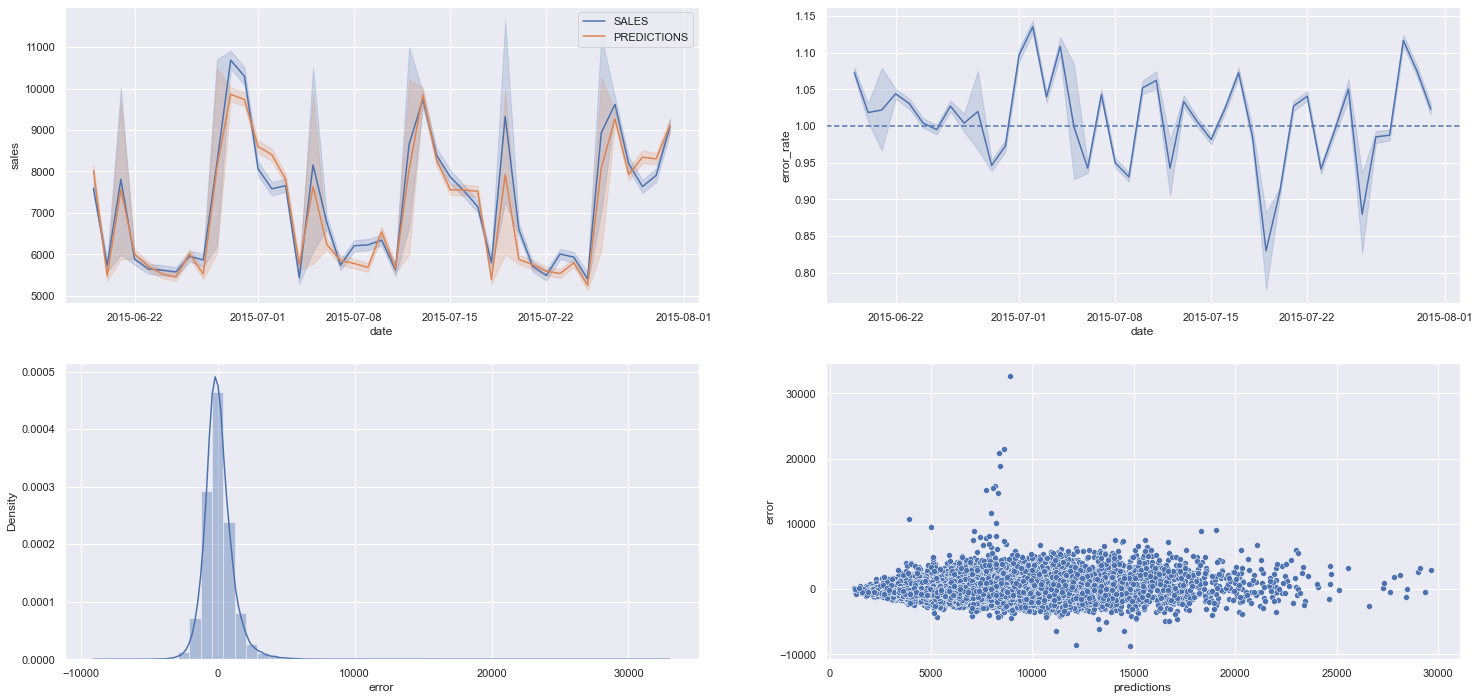

In [98]:
# Analisando o que foi previsto com as vendas reais, considerando a margem de erro.
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

# Analisando se o modelo está subestimando ou superestimando
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

# Análise de resíduos
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

# Resíduos
plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [99]:
# Save trained model
pickle.dump( model_xgb_tuned, open('model/model_rossmann.pkl', 'wb' ) )

## 10.1. Rossmann Class

In [100]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.competition_distance_scaler = pickle.load( open('parameter/competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open('parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler = pickle.load( open('parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler = pickle.load( open('parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler = pickle.load( open('parameter/store_type_scaler.pkl', 'rb' ) )
        
    def data_cleaning( self, df1):
    
        ## 1.1. Rename Columns
#         cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
#                'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
#                'CompetitionDistance', 'CompetitionOpenSinceMonth',
#                'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
#                'Promo2SinceYear', 'PromoInterval']
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old))

        df1.columns = cols_new

        ## 1.3. Data Types

        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA

        # competition_distance          
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        # competition_open_since_month  
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        # competition_open_since_year   
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        # promo2_since_week             
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        # promo2_since_year             
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        # promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May',6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

#         df1.sample( 5 ).T

        ## 1.6. Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

        return df1

    def feature_engineering( self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( int ).astype( str ) + '-' + df2['promo2_since_week'].astype( int ).astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        
        ## 3.1. Filtragem das Linhas

        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
        
    def data_preparation( self, df5 ):

        ## 5.1. Normalização

        ## 5.2. Rescaling

     
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )
#         df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week 
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )

        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        ## 5.3. Transformação

        ### 5.3.1. Encoding

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )        

        # assortment - Ordinal Encoding
        assortment_dic = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dic )

        ### 5.3.2. Response Variable Transformation

#         df5['sales'] = np.log1p( df5['sales'] )        

        
        ### 5.3.3. Nature Transformation        

        # day of week - Reinicia o ciclo a cada 7 dias
        reinicia_ciclo = 7
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/reinicia_ciclo ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/reinicia_ciclo ) ) )

        # month
        reinicia_ciclo = 12
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/reinicia_ciclo ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/reinicia_ciclo ) ) )

        # day - Como tem mêses que tem 28,30,31 dias usei como base 30 para todos.
        reinicia_ciclo = 30
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/reinicia_ciclo ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/reinicia_ciclo ) ) )

        # week of year
        reinicia_ciclo = 52
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/reinicia_ciclo ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/reinicia_ciclo ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
                         'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
                         'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )
    


## 10.2. API Handler

In [101]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading Model
model = pickle.load( open( 'model/model_rossmann.pkl', 'rb') )


app = Flask( __name__)

@app.route( '/status', methods=['GET'] )
def status():    
    return Response( 'API Rossmann funcionando com sucesso! \n acesse /help para listar rotas!', status=200, mimetype='application/json' )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
        
    if test_json: #there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instance Rossman class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )     
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

# if __name__ == '__main__':
#     app.run( '127.0.0.1' )

## 10.3. API Tester

In [8]:
df10 = pd.read_csv( 'dados/test.csv')

In [11]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

# chose store for prediction
df_test = df_test[df_test['Store'].isin( [22, 12, 24]) ]

# remove closed days
df_test = df_test[df_test['Open'] != 0 ]
df_test = df_test[~df_test['Open'].isnull() ]
df_test = df_test.drop( 'Id', axis=1 )

In [12]:
data = json.dumps( df_test.to_dict( orient='records'))

In [15]:
# API Call
# url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-model-predict.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header)
print(f'Status Code { r.status_code}')

Status Code 200


In [16]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())


In [17]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 12 will sell R$316,549.31 in the next 6 weeks
Store Number 22 will sell R$195,921.52 in the next 6 weeks
Store Number 24 will sell R$392,812.70 in the next 6 weeks


In [18]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,8161.744141
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,5220.715332
2,24,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,...,2015,9,17,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,10010.204102
3,12,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,8417.211914
4,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,5380.939453
